<a href="https://www.kaggle.com/code/faduregis/npl-character-level-rnn-to-classify-names?scriptVersionId=158541634" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Classifying Names with a Character-Level RNN**

Included in the data/names directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized

In [1]:
import torch
device = torch.device("cpu")

In [2]:
from __future__ import unicode_literals, print_function, division
import glob #What is the function of glob?
import os
from io import open

def findFiles(path): return glob.glob(path)

print(findFiles('../input/nlp-names/*.txt'))

['../input/nlp-names/Vietnamese.txt', '../input/nlp-names/Greek.txt', '../input/nlp-names/Japanese.txt', '../input/nlp-names/Dutch.txt', '../input/nlp-names/Irish.txt', '../input/nlp-names/Russian.txt', '../input/nlp-names/Korean.txt', '../input/nlp-names/Scottish.txt', '../input/nlp-names/Czech.txt', '../input/nlp-names/Italian.txt', '../input/nlp-names/Arabic.txt', '../input/nlp-names/Portuguese.txt', '../input/nlp-names/Spanish.txt', '../input/nlp-names/Chinese.txt', '../input/nlp-names/French.txt', '../input/nlp-names/English.txt', '../input/nlp-names/German.txt', '../input/nlp-names/Polish.txt']


In [3]:
import unicodedata #What does "unicdedata" allow us to do here?
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../input/nlp-names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [6]:
import torch
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)
print (letterToIndex('J'))

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor
print(letterToTensor('J'))

# Turn a line into a <line_length x 1 x n_letters>, or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor
print (letterToIndex('J'))

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

print (letterToIndex('J'))

35
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
35
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])
35


In [7]:
    import torch.nn as nn

    class RNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(RNN, self).__init__()

            self.hidden_size = hidden_size

            self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
            self.i2o = nn.Linear(input_size + hidden_size, output_size)
            self.softmax = nn.LogSoftmax(dim=1)

        def forward(self, input, hidden):
            combined = torch.cat((input, hidden), 1)
            hidden = self.i2h(combined)
            output = self.i2o(combined)
            output = self.softmax(output)
            return output, hidden

        def initHidden(self):
            return torch.zeros(1, self.hidden_size)

In [8]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


In [10]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8671, -2.8253, -2.8599, -2.9186, -2.9479, -2.8824, -2.9650, -2.9999,
         -2.9063, -2.8210, -2.8711, -2.8803, -2.9350, -2.7916, -2.8990, -2.9370,
         -2.8668, -2.8765]], grad_fn=<LogSoftmaxBackward0>)


In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
print(categoryFromOutput(output))

('Chinese', 13)


In [12]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
    
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Urena
category = Dutch / line = Seghers
category = Japanese / line = Shichirobei
category = Greek / line = Stamatelos
category = Korean / line = So
category = Scottish / line = Cunningham
category = Russian / line = Bagdatiev
category = Arabic / line = Naifeh
category = German / line = Schreier
category = French / line = Fortier


In [13]:
criterion = nn.NLLLoss() # What is the NLLLoss and why it is a good choice here?

In [14]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

In [15]:
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [16]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [17]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.8158 Baz / Chinese ✗ (Arabic)
10000 10% (0m 13s) 2.5696 Nascimbene / Greek ✗ (Italian)
15000 15% (0m 20s) 1.0100 Shui / Chinese ✓
20000 20% (0m 26s) 1.3080 Ma / Vietnamese ✓
25000 25% (0m 33s) 2.3906 Parma / Portuguese ✗ (Italian)
30000 30% (0m 39s) 2.5110 Jacobson / Scottish ✗ (English)
35000 35% (0m 46s) 0.5404 Tong / Vietnamese ✓
40000 40% (0m 53s) 3.3329 Gaspar / Arabic ✗ (Portuguese)
45000 45% (1m 0s) 4.4764 Mollo / Italian ✗ (Russian)
50000 50% (1m 7s) 0.7658 Rosario / Portuguese ✓
55000 55% (1m 13s) 1.5482 Berg / Dutch ✗ (German)
60000 60% (1m 20s) 1.4982 Kloet / Dutch ✓
65000 65% (1m 27s) 0.8964 Cvacek / Czech ✓
70000 70% (1m 34s) 2.6523 Mathieu / Vietnamese ✗ (French)
75000 75% (1m 40s) 0.4543 Osagawa / Japanese ✓
80000 80% (1m 47s) 0.9088 Araujo / Portuguese ✓
85000 85% (1m 54s) 0.5902 Sin / Korean ✓
90000 90% (2m 1s) 0.5418 Ciardha / Irish ✓
95000 95% (2m 8s) 0.6020 Skeril / Czech ✓
100000 100% (2m 15s) 1.8288 Severins / French ✗ (Dutch)


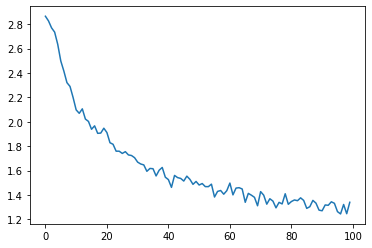

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


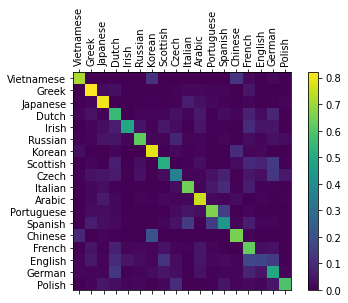

In [19]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [20]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.55) Czech
(-1.57) Russian
(-1.95) Polish

> Jackson
(-1.35) Scottish
(-1.41) English
(-1.88) Russian

> Satoshi
(-1.10) Japanese
(-1.50) Italian
(-1.73) Arabic


In [21]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Francois')
predict('Regis')


> Dovesky
(-0.55) Czech
(-1.57) Russian
(-1.95) Polish

> Jackson
(-1.35) Scottish
(-1.41) English
(-1.88) Russian

> Satoshi
(-1.10) Japanese
(-1.50) Italian
(-1.73) Arabic

> Francois
(-1.48) Portuguese
(-1.51) Spanish
(-1.73) French

> Regis
(-1.15) Greek
(-1.76) Portuguese
(-2.02) French
